## Load Python Libraries
Run this chunk before moving to any other section

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Reading raw data into Google Colab


Zip folder of datasets. This folder contains 2 subdirectories, with datasets from GLUE and KAGGLE respectively.

Link to zip folder: https://drive.google.com/file/d/1Agr-KtAGWu3PSZ05BHZfrCBvJd4R18yK/view?usp=drive_link

Link to folder (to check files): https://drive.google.com/drive/folders/1oSvNYenOhN1YU-yF-mWwwkjJArfYH2e9?usp=drive_link

* /GLUE/
  * dev.tsv
  * train.tsv
  * test.tsv
* /KAGGLE/
  * train.csv
  * test.csv

**_Running the code chunk below will allow data to be accessible in /data_**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gdown
import zipfile

id = "1Agr-KtAGWu3PSZ05BHZfrCBvJd4R18yK" # add id of zipped data folder uploaded to Google Drive
gdown.download(id=id)
with zipfile.ZipFile('/content/data.zip', mode = 'r') as zip_ref:
  zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=1Agr-KtAGWu3PSZ05BHZfrCBvJd4R18yK
To: /content/data.zip
100%|██████████| 182M/182M [00:01<00:00, 118MB/s]


## Data Pre-Processing

In [30]:
df_kaggle_train = pd.read_csv('data/KAGGLE/train.csv')
df_kaggle_test = pd.read_csv('data/KAGGLE/test.csv')
df_glue_train = pd.read_csv('data/GLUE/train.tsv', sep = '\t')
df_glue_test = pd.read_csv('data/GLUE/test.tsv', sep = '\t')
df_glue_dev = pd.read_csv('data/GLUE/dev.tsv', sep = '\t')

Checking for duplicate rows.

In [ ]:
duplicate_rows = df_kaggle_test[df_kaggle_test.duplicated(['question1', 'question2'])]
print(f'There are {duplicate_rows.shape[0]} duplicate rows for KAGGLE/test.csv.')

duplicate_rows = df_glue_test[df_glue_test.duplicated(['question1', 'question2'])]
print(f'There are {duplicate_rows.shape[0]} duplicate rows for GLUE/test.tsv.')

duplicate_rows = df_kaggle_train[df_kaggle_train.duplicated(['qid1', 'qid2'])]
print(f'There are {duplicate_rows.shape[0]} duplicate rows for KAGGLE/train.csv.')

duplicate_rows = df_glue_train[df_glue_train.duplicated(['qid1', 'qid2'])]
print(f'There are {duplicate_rows.shape[0]} duplicate rows for GLUE/train.tsv.')

duplicate_rows = df_glue_dev[df_glue_dev.duplicated(['qid1', 'qid2'])]
print(f'There are {duplicate_rows.shape[0]} duplicate rows for GLUE/dev.tsv.')

There are 5397 duplicate rows for KAGGLE/test.csv.
There are 5342 duplicate rows for GLUE/test.tsv.
There are 0 duplicate rows for KAGGLE/train.csv.
There are 0 duplicate rows for GLUE/train.tsv.
There are 0 duplicate rows for GLUE/dev.tsv.


In [ ]:
df_combined_train = pd.concat([df_kaggle_train, df_glue_train, df_glue_dev])
df_combined_test = pd.concat([df_kaggle_test, df_glue_test])

# Dropping unnecessary columns
df_combined_test = df_combined_test.drop(columns=['test_id', 'id'])

We decided to go with the combined training datasets since the testing datasets are unlabeled.

In [ ]:
df = df_combined_train

## Preliminary Data Analysis

Checking for duplicate rows.

In [ ]:
duplicate_rows = df[df.duplicated(['qid1', 'qid2'])]
total_num_rows = df.shape[0]
total_num_duplicate_rows = duplicate_rows.shape[0]
total_num_unique_rows = total_num_rows - total_num_duplicate_rows

print("===")
print("Number of total rows:", total_num_rows)
print("Number of duplicate rows:", total_num_duplicate_rows)
print("Ratio of duplicate rows:", round(100*total_num_duplicate_rows/total_num_rows, 4))

# Removing duplicated rows
df = df.drop_duplicates()
print("=== AFTER REMOVAL OF DUPLICATED ROWS FROM df")
print("Number of unique rows:", df.shape[0])
print("===")

===
Number of total rows: 808566
Number of duplicate rows: 404276
Ratio of duplicate rows: 49.9991
=== AFTER REMOVAL OF DUPLICATED ROWS FROM df
Number of unique rows: 404290
===


Check for invalid/null values/empty rows.

In [ ]:
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


As there are very few entries with null values, we will remove them.

In [ ]:
df.dropna(inplace=True)
df = df.loc[:, ('question1','question2','is_duplicate')]
df

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...
404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,What is one coin?,What's this coin?,0
404288,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


Check if we have imbalanced data

In [ ]:
print('===')
print(f'Dataframe: df')
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns}')
print('Classes:')
df_duplicates = df[df['is_duplicate']==1]
df_non_duplicates = df[df['is_duplicate']==0]
print(f'- Duplicate questions: {df_duplicates.shape[0]}')
print(f'- Non-duplicate questions: {df_non_duplicates.shape[0]}')
print('===')

===
Dataframe: df
Shape: (404287, 3)
Columns: Index(['question1', 'question2', 'is_duplicate'], dtype='object')
Classes:
- Duplicate questions: 149263
- Non-duplicate questions: 255024
===


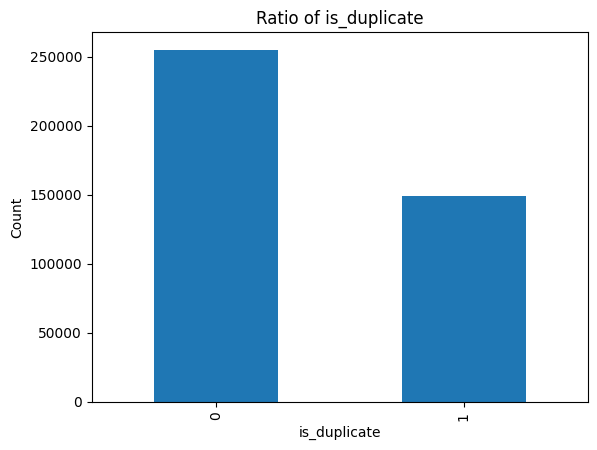

In [ ]:
# Count the occurrences of each label value
is_duplicates = df.groupby("is_duplicate")["question1"].count()

is_duplicates.plot(kind='bar')
plt.xlabel("is_duplicate")
plt.ylabel("Count")
plt.title("Ratio of is_duplicate")
plt.show()

In [ ]:
not_similar_percentage = 100 - round(df['is_duplicate'].mean() * 100, 2)
similar_percentage = round(df['is_duplicate'].mean() * 100, 2)

print(f"Question pairs that are not similar (is_duplicate = 0): {not_similar_percentage}%")
print(f"Question pairs that are similar (is_duplicate = 1): {similar_percentage}%")

Question pairs that are not similar (is_duplicate = 0): 63.08%
Question pairs that are similar (is_duplicate = 1): 36.92%


Maximum number of times a single question is repeated: 161
Number of questions that appear multiple times: 111870


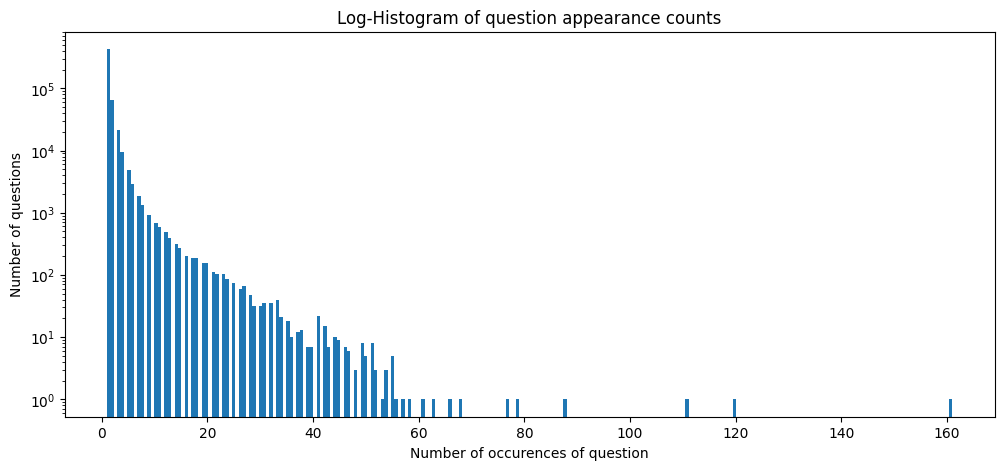

In [ ]:
qids = pd.concat([df['question1'], df['question2']], ignore_index=True)
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=250)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print('Maximum number of times a single question is repeated: {}'.format(max(qids.value_counts())))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

## Data Cleaning



In [5]:
#Concverting to lowercase
def to_lower(text):
    if isinstance(text, str):
      lt=text.lower()
      return lt
    else:
      return text

#Removing Contractions
!pip install contractions
import contractions
def expand_contractions(text):
    if isinstance(text, str):
        expanded_text = contractions.fix(text)
        return expanded_text
    else:
        return text

#Removing Hyperlinks
import re
def rm_hyperlinks(text):
    result = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return result

#Removing HTML Tags
from bs4 import BeautifulSoup
def remove_html_tags(text):
    if isinstance(text, str):
        return BeautifulSoup(text, 'html.parser').get_text()
    else:
        return text

# Standardizing Accent Characters, convert characters into standard ASCII characters, Remove non english characters
import unicodedata
def standardize_accented_chars(text):
  if isinstance(text, str):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  else:
      return text


#Removing Mentions and Hashtags
def remove_mentions_and_tags(text):
  if isinstance(text, str):
    text = re.sub(r'@\S*','', text)
    return re.sub(r'#\S*','', text)
  else:
    return text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
df["question1"]=df["question1"].apply(to_lower)
df["question2"]=df["question2"].apply(to_lower)
df["question1"]=df["question1"].apply(expand_contractions)
df["question2"]=df["question2"].apply(expand_contractions)
df["question1"]=df["question1"].apply(remove_html_tags)
df["question2"]=df["question2"].apply(remove_html_tags)
df["question1"]=df["question1"].apply(standardize_accented_chars)
df["question2"]=df["question2"].apply(standardize_accented_chars)
df["question1"]=df["question1"].apply(remove_mentions_and_tags)
df["question2"]=df["question2"].apply(remove_mentions_and_tags)

## Feature engineering

Features:
1. Length of questions ratio
2. Number of words ratiio
3. Jaccard similarity
4. Cosine similarity
5. Fuzzy Features
6. Common stop words to unique words ratio
7. Same first and last words
8. Common words to unique words ratio


Input: df with the following columns - ['question1', 'question2', 'is_duplicate']

Output: updated df with 11 features

### Length of questions ratio

Finding the ratio of the length of the shorter question over the length of the longer question

In [ ]:
df['q1_length'] = df['question1'].str.len()
df['q2_length'] = df['question2'].str.len()

In [ ]:
df['length_ratio'] = df[['q1_length', 'q2_length']].min(axis=1) / df[['q1_length', 'q2_length']].max(axis=1)


### Number of words ratio

Finding the ratio of the number of words in the shorter question over the length of the longer question

In [ ]:
df['q1_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
df['num_words_ratio'] = df[['q1_words', 'q2_words']].min(axis=1) / df[['q1_words', 'q2_words']].max(axis=1)


### Lemmatizing the words

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.metrics import jaccard_distance

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize the tokens
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]  # Remove stop words
    return set(filtered_tokens)  # Convert the list to a set




In [ ]:
df['question1_tokens'] = df['question1'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)
df['question2_tokens'] = df['question2'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)

### Jaccard Similarity

In [8]:
# Calculate Jaccard similarity
def calculate_jaccard_similarity(row):
    set1 = row['question1_tokens']
    set2 = row['question2_tokens']
    if not isinstance(set1, set) or not isinstance(set2, set):
        return 0  # If one or both values are not sets, return 0 (no similarity)
    if len(set1) == 0 or len(set2) == 0:
        return 0  # If one or both sets are empty, return 0 (no similarity)
    return 1 - jaccard_distance(set1, set2)




In [ ]:
df['jaccard_similarity'] = df.apply(calculate_jaccard_similarity, axis=1)

### Cosine Similarity


In [ ]:
df.fillna(' ')

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def cosine_similarity_strings(str1, str2):
  try:
    # Create a CountVectorizer to convert text to a bag of words representation
    vectorizer = CountVectorizer()

    # Fit and transform the strings to vectorized representations
    vectors = vectorizer.fit_transform([str1, str2])

    # Calculate the cosine similarity between the two vectors
    cosine_sim = cosine_similarity(vectors[0], vectors[1])

    return cosine_sim[0, 0]
  except ValueError:
    return 0

In [ ]:
df['cosine_similarity'] = df.apply(lambda row: cosine_similarity_strings(row['question1'], row['question2']), axis=1)

According to the plot, some features are useful in distinguishing between the 2 target classes of `is_duplicate` as those that are duplicated generally have a higher ratio score.

### Common stop words to Unique words ratio

In [10]:
def common_stopwords_ratio(str1,str2):
    words1 = str1.split()
    words2 = str2.split()
    if len(words1) == 0 or len(words2) ==0:
      return 0
    stop_words = set(stopwords.words('english'))
    q1_stops = set([word for word in words1 if word in stop_words])
    q2_stops = set([word for word in words2 if word in stop_words])
    common_stop_count = len(q1_stops.intersection(q2_stops))
    length = len(words1)+len(words2) - len(set(words1).intersection(set(words2)))
    return common_stop_count/length

In [ ]:

df['csc_ratio']= df.apply(lambda row: common_stopwords_ratio(row['question1'], row['question2']), axis=1)

### Same First and Last Words

In [11]:
def share_same_firstandlast_word(str1, str2):
    words1 = str1.split()  # Split the first string into words
    words2 = str2.split()  # Split the second string into words
    if len(words1) == 0 or len(words2) == 0:
      return 0
    if words1[-1] == words2[-1] and words1[0] == words2[0] :
      return 1
    else:
      return 0

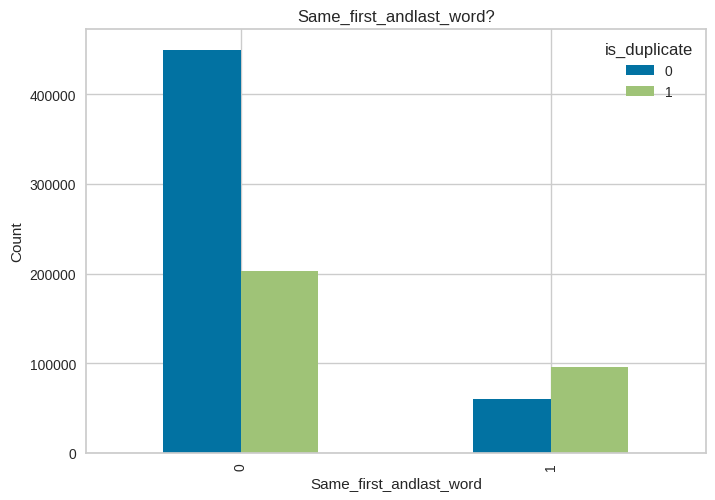

In [ ]:
df['Same_first_andlast_word']= df.apply(lambda row: share_same_firstandlast_word(row['question1'], row['question2']), axis=1)
counts = df.groupby(["Same_first_andlast_word", "is_duplicate"]).size().unstack(fill_value=0)
counts
counts.plot(kind='bar', stacked=False)
plt.xlabel("Same_first_andlast_word")
plt.ylabel("Count")
plt.title("Same_first_andlast_word?")
plt.legend(title="is_duplicate")
plt.show()


###Common words to Unique Words Ratio

In [12]:
def common_word_ratio(column1, column2):
    set1 = set(column1.split())
    set2 = set(column2.split())
    common_words = set1.intersection(set2)
    total_unique_words = len(set1) + len(set2) - len(common_words)

    if total_unique_words == 0:
        return 0
    else:
        return len(common_words) / total_unique_words

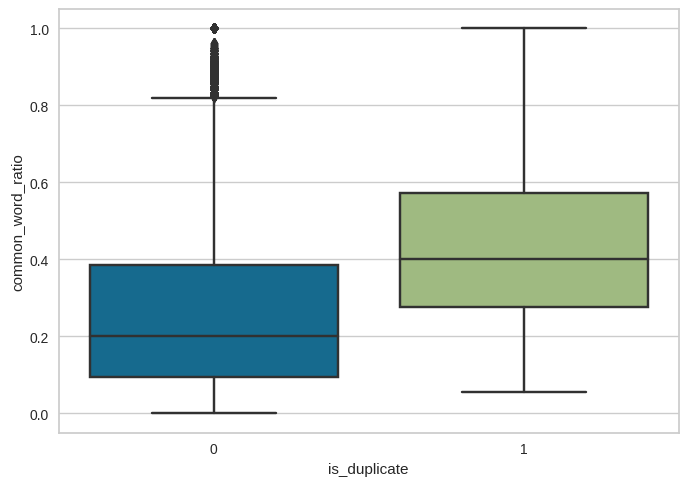

In [ ]:
df['common_word_ratio']= df.apply(lambda row: common_word_ratio(row['question1'], row['question2']), axis=1)

df['common_word_ratio'].head()
import seaborn as sns
sns.boxplot(x="is_duplicate",y='common_word_ratio',data=df)
plt.show()

### Fuzzy Features

Fuzz Simple Ratio algorithm, also known as Levenshtein distance, measures the similarity between two strings by calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into the other.  Jaccard distance is more appropriate if we are measuring similarity based on shared words and don't care about word order,however if we are measuring similarity considering the order of words and the number of operations required to transform one question into the other, then Levenshtein distance might be a better choice.

In [22]:
!pip3 install fuzzywuzzy
!pip3 install levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.2 MB/s eta 0:00:00


In [23]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
df['Simple_Ratio']=df.apply(lambda x: fuzz.ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)

* Fuzz Partial Ratio is useful when you want to find the similarity between two strings, focusing only on the best matching substring. It is particularly effective for identifying matches when one string is a subset or prefix of the other.


* Token Set Ratio algorithm tokenizes both input strings, removes duplicate tokens, and calculates the similarity score based on the intersection and union of the token sets. It captures the essence of the strings' content rather than their specific order.


* Token Sort Ratio algorithm tokenizes both input strings, sorts the tokens alphabetically, and calculates the similarity score based on the Fuzz Ratio between the sorted token lists. It handles cases where word order differs but the same set of words exists in both strings





In [ ]:
df['Partial_Ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1_tokens'],x['question2_tokens'])/100,axis=1)
df['Token_Sort_Ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)
df['Token_Set_Ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)



In [ ]:
df.head()

,question1,question2,is_duplicate,question1_tokens,question2_tokens,jaccard_similarity,cosine_similarity,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,"{india, market, ?, step, share, invest, guide}","{market, ?, step, share, invest, guide}",0.857143,0.944911,0.92,0.98,0.91,1.00
1,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,"{story, koh-i-noor, ?, ), (, diamond, kohinoor}","{koh-i-noor, happen, government, ), ?, (, woul...",0.461538,0.583333,0.59,0.69,0.61,0.90
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,"{connection, ?, internet, using, vpn, increase...","{dns, increased, hacking, internet, ?, speed}",0.300000,0.365148,0.61,0.64,0.70,0.70
3,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,"{?, lonely, mentally, solve}","{}, divided, remainder, /math, ], math, 24,23,...",0.062500,0.000000,0.32,0.47,0.22,0.22
4,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,"{salt, ,, carbon, di, water, oxide, quikly, ?,...","{survive, salt, fish, water, ?, would}",0.200000,0.419314,0.46,0.60,0.40,0.51


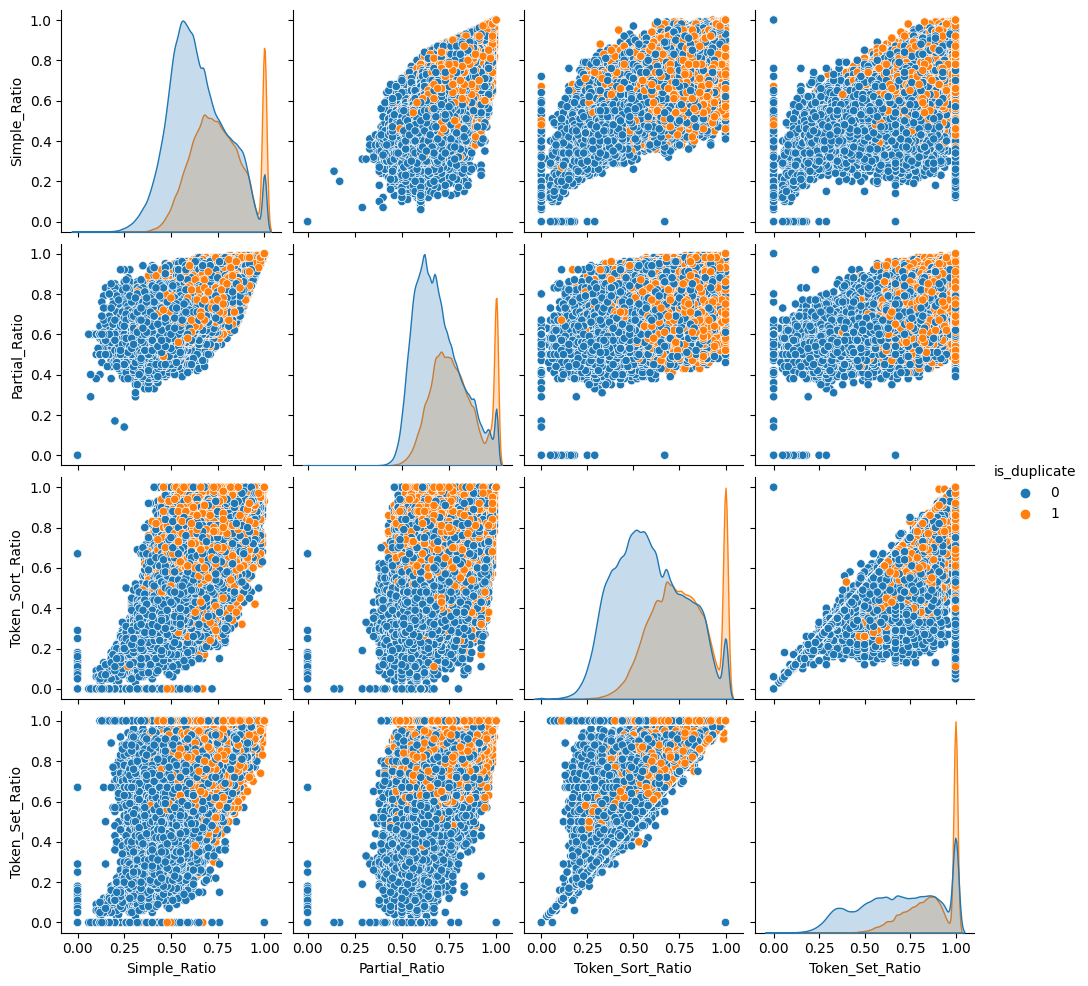

In [ ]:
import seaborn as sns
n = df.shape[0]
sns.pairplot(df[['Simple_Ratio', 'Partial_Ratio','Token_Sort_Ratio',
        'Token_Set_Ratio', 'is_duplicate']][0:n],hue='is_duplicate')

# ## change to correlation table

### Correlation Matrix

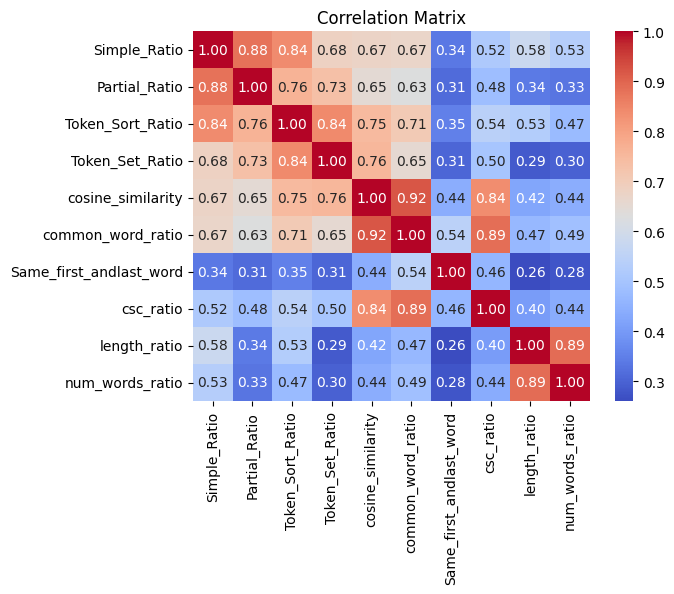

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
selected_col=[ 'Simple_Ratio',	'Partial_Ratio',	'Token_Sort_Ratio',	'Token_Set_Ratio',"cosine_similarity", 'common_word_ratio',
              'Same_first_andlast_word','csc_ratio','length_ratio','num_words_ratio']
selected_df=df[selected_col]
correlation_matrix = selected_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Saving of features

In [ ]:
## this code save features into csv - do not need to rerun unless there are additional features

# from google.colab import files
# df.to_csv('df_with_features.csv', encoding = 'utf-8-sig')
# files.download("df_with_features.csv")

In [ ]:
import gdown
# add link of csv to Google Drive
id = "12_K_aQoy7Oulr7js0f8EVcMQui2TjfmK"
gdown.download(id=id,output="/content/df_with_features.csv")

In [ ]:
df_with_features = pd.read_csv('/content/df_with_features.csv')

### Semantic features
Featurising text data with tfidf weighted word-vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])
questions = [str(text) for text in questions if not pd.isnull(text)]

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

Using pretrained GLOVE model to have a more robust understanding of word semantics

In [14]:
!python -m spacy download en_core_web_lg

2023-12-02 06:45:31.953581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 06:45:31.953659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 06:45:31.953705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 06:45:33.050354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
df_qns = pd.DataFrame()
import spacy
from tqdm import tqdm
from google.colab import files
nlp_model = spacy.load('en_core_web_lg')

vecs1 = []
df['question1'] = df['question1'].astype(str)
for qu1 in tqdm(list(df['question1'])):

    doc = nlp_model(qu1)

    mean_vec1 = np.zeros([len(doc), len(doc[0].vector)])

    for word in doc:

        #word2vec
        vec1 = word.vector

        #fetch score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_qns = pd.DataFrame()
df_qns['q1_feats'] = list(vecs1)



df_qns.to_csv('df_qns.csv')
files.download('df_qns.csv')

100%|██████████| 808563/808563 [2:15:57<00:00, 99.12it/s]


In [ ]:
from tqdm import tqdm
import spacy
nlp_model = spacy.load('en_core_web_lg')
vecs2 = []
df_qns2 = pd.DataFrame()
for qu2 in tqdm(list(df['question2'])):
    doc = nlp_model(qu2)
    mean_vec2 = np.zeros([len(doc), len(doc[0].vector)])
    for word in doc:
        vec2 = word.vector
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_qns2['q2_feats'] = list(vecs2)




In [ ]:
df_qns2.to_csv('df_qns2.csv')
files.download('df_qns2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved the dataframes due to long runtime of the above codes to ensure progress is saved

### Formatting of dfs

In [ ]:
df_qns1 = pd.read_csv('df_qns.csv')
chunk_size = 1000
chunks = [df_qns1[i:i + chunk_size] for i in range(0, len(df_qns1), chunk_size)]

In [ ]:
# cleaning of saved csv
import re
import json
import ast



def clean_list(entry):
    entry = re.sub(r'\[\s+', '[', entry)
    entry = re.sub(r'\s+', ',', entry)
    entry = re.sub(r',+', ',', entry)
    return entry

In [ ]:
df_qns1['q1_feats'] = df_qns1['q1_feats'].apply(clean_list)

In [ ]:
result_chunks = []
from tqdm import tqdm
for i in tqdm(range(0, len(df_qns1), chunk_size)):
    chunk = df_qns1['q1_feats'].iloc[i:i + chunk_size]
    df_qns1.loc[chunk.index, 'q1_feats'] = chunk.apply(ast.literal_eval)

In [ ]:
df_qns1 = pd.concat([df_qns2['q1_feats'].apply(pd.Series)], axis=1)
df_qns1.columns = ['qn1_' + str(col) for col in df_qns1.columns]

In [ ]:
df_qns2 = pd.read_csv('df_qns2.csv')

In [ ]:
# cleaning of saved csv
import re
import json
import ast
chunk_size = 1000
chunks = [df_qns2[i:i + chunk_size] for i in range(0, len(df_qns2), chunk_size)]

def clean_list(entry):
    entry = re.sub(r'\[\s+', '[', entry)
    entry = re.sub(r'\s+', ',', entry)
    entry = re.sub(r',+', ',', entry)
    return entry

In [ ]:
df_qns2['q2_feats'] = df_qns2['q2_feats'].apply(clean_list)

In [ ]:
result_chunks = []
from tqdm import tqdm
for i in tqdm(range(0, len(df_qns2), chunk_size)):
    chunk = df_qns2['q2_feats'].iloc[i:i + chunk_size]
    df_qns2.loc[chunk.index, 'q2_feats'] = chunk.apply(ast.literal_eval)

In [ ]:
df_qns2 = pd.concat([df_qns2['q2_feats'].apply(pd.Series)], axis=1)
df_qns2.columns = ['qn2_' + str(col) for col in df_qns1.columns]

In [ ]:
result_df = pd.merge(df_with_features, df_qns1, left_index=True, right_index=True)
result_df = pd.merge(result_df, df_qns2, left_index=True, right_index=True)

In [ ]:
result_df.head()

,Unnamed: 0,q1_length,q2_length,q1_num_words,q2_num_words,is_duplicate,jaccard_similarity,cosine_similarity,Simple_Ratio,Partial_Ratio,...,qn2_290,qn2_291,qn2_292,qn2_293,qn2_294,qn2_295,qn2_296,qn2_297,qn2_298,qn2_299
0,0,66.0,57,14,12,0,0.857143,0.944911,0.92,0.98,...,90.303521,-109.123376,-105.312638,94.447703,21.352271,-15.721139,-14.508049,-128.558803,-125.633695,89.503707
1,1,51.0,88,8,13,0,0.461538,0.583333,0.59,0.69,...,63.882537,51.893688,103.323957,42.417593,-114.563457,42.004470,-92.079150,37.738239,-116.143929,80.443789
2,2,73.0,59,14,10,0,0.300000,0.365148,0.61,0.64,...,92.047050,-34.995940,48.155468,86.329399,-55.403264,116.666617,129.660832,-212.609825,-69.998551,180.970510
3,3,50.0,65,11,9,0,0.062500,0.000000,0.32,0.47,...,55.419788,-52.267296,-16.195997,33.630910,-68.004602,54.898027,-53.521680,-137.538440,-2.546923,41.026164
4,4,76.0,39,13,7,0,0.200000,0.419314,0.46,0.60,...,101.274531,-56.145572,110.791427,-53.770879,-152.828185,-51.680481,16.801956,-54.410770,-28.281943,-0.370436


In [ ]:
result_df.shape

(808563, 615)

In [ ]:
print(result_df.columns)

Index(['Unnamed: 0', 'q1_length', 'q2_length', 'q1_num_words', 'q2_num_words',
       'is_duplicate', 'jaccard_similarity', 'cosine_similarity',
       'Simple_Ratio', 'Partial_Ratio',
       ...
       'qn2_290', 'qn2_291', 'qn2_292', 'qn2_293', 'qn2_294', 'qn2_295',
       'qn2_296', 'qn2_297', 'qn2_298', 'qn2_299'],
      dtype='object', length=615)


Creating features ```semantic_cosine_similarity```,```semantic_euclidean_distance``` to relate the word vectors generated for qns1 and qns2 together





In [ ]:
q1_feats = [col for col in result_df.columns if 'qn1_' in col]
q2_feats = [col for col in result_df.columns if 'qn2_' in col]

# Initialize lists to store similarity and distance results
cosine_similarities = []
euclidean_distances = []

# Iterate over each pair of qn1 and qn2 columns to calculate similarity and difference metrics
for qn1_col, qn2_col in zip(q1_feats, q2_feats):
    # Compute semantic similarity metric (e.g., cosine similarity)
    cosine_similarity = [np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)) for x, y in zip(result_df[qn1_col], result_df[qn2_col])]
    cosine_similarities.append(cosine_similarity)

    # Compute semantic difference metric (e.g., Euclidean distance)
    euclidean_distance = [np.linalg.norm(x - y) for x, y in zip(result_df[qn1_col], result_df[qn2_col])]
    euclidean_distances.append(euclidean_distance)

# Add the aggregated similarity and distance to result_df
result_df['semantic_cosine_similarity'] = np.mean(cosine_similarities, axis=0)
result_df['semantic_euclidean_distance'] = np.mean(euclidean_distances, axis=0)

semantic_correlations = []

for index, row in result_df.iterrows():
    # Initialize lists to store X and Y values for the current row
    X_values = []
    Y_values = []

    # Collect X values (qn1_0, qn1_1, qn1_2)
    X_values.extend([row[col] for col in q1_feats])

    # Collect Y values (qn2_0, qn2_1, qn2_2)
    Y_values.extend([row[col] for col in q2_feats])

    # Calculate the correlation between X and Y for the current row
    correlation = np.corrcoef(X_values, Y_values)[0, 1]

    # Append the correlation coefficient to the list
    semantic_correlations.append(correlation)

result_df['semantic_correlations'] = semantic_correlations

result_df.drop(q1_feats + q2_feats, axis=1, inplace=True)

In [ ]:
result_df.to_csv('df_features_with_semantics.csv',,index=False)

### End of Feature Engineering

# Load df with final features for ML
Run the lines below to get the final df with all features.

After getting all the features, duplicates were dropped as they were due to duplicates in the raw dataset. Additionally, rows with na were dropped to ensure that tree methods could work.



In [ ]:
import gdown

# add link of csv to Google Drive
id = "1lLDHA0YY_ddHE0Msbjdl0oWI9SNJPYw0"
gdown.download(id=id,output="/content/df_features_with_semantics.csv")

Downloading...
From: https://drive.google.com/uc?id=1lLDHA0YY_ddHE0Msbjdl0oWI9SNJPYw0
To: /content/df_features_with_semantics.csv
100%|██████████| 132M/132M [00:00<00:00, 144MB/s]


'/content/df_features_with_semantics.csv'

In [ ]:
df = pd.read_csv('/content/df_features_with_semantics.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.drop_duplicates()
df.dropna(subset=['semantic_cosine_similarity'], inplace=True)

All features have been normalised except semantic_euclidean_distance so it is normalised below.

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# Normalise semantic_euclidean_distance
column_data = df['semantic_euclidean_distance'].values.reshape(-1, 1)
scaler = MinMaxScaler()
normalized_column = scaler.fit_transform(column_data)
df['semantic_euclidean_distance'] = normalized_column

In [ ]:
df.head()

,is_duplicate,jaccard_similarity,cosine_similarity,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,csc_ratio,Same_first_andlast_word,common_word_ratio,semantic_cosine_similarity,semantic_euclidean_distance,semantic_correlations,length_ratio,num_words_ratio
0,0,0.857143,0.944911,0.92,0.98,0.91,1.00,0.375000,0,0.769231,0.913333,0.009838,0.990396,0.863636,0.857143
1,0,0.461538,0.583333,0.59,0.69,0.61,0.90,0.117647,0,0.250000,0.360000,0.034554,0.555015,0.579545,0.615385
2,0,0.300000,0.365148,0.61,0.64,0.70,0.70,0.100000,0,0.200000,0.626667,0.029251,0.834663,0.808219,0.714286
3,0,0.062500,0.000000,0.32,0.47,0.22,0.22,0.000000,0,0.000000,0.240000,0.048808,0.324495,0.769231,0.818182
4,0,0.200000,0.419314,0.46,0.60,0.40,0.51,0.111111,0,0.111111,0.506667,0.058883,0.704825,0.513158,0.538462


In [ ]:
df.shape

(403101, 15)

# Model Evaluation Functions

`print_train_test_metrics` is used to print all Train and Test evaluation metrics for our models. These metrics were used when we first tested each model and for model tuning


In [ ]:
def print_train_test_metrics(fitted_model, X_train, y_train, X_test, y_test):
  def line():
      print("=======================")
  def blank_space(n=1):
      for i in range(n):
          print("")

  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  line()
  print("Train-Test Split Results")
  line()

  blank_space()
  print("TRAIN RESULTS")
  y_pred_train = fitted_model.predict(X_train)
  print(f'Accuracy: {accuracy_score(y_train,y_pred_train)}')
  print(f'Precision: {precision_score(y_train,y_pred_train)}')
  print(f'Recall: {recall_score(y_train,y_pred_train)}')
  print(f'F1 Score: {f1_score(y_train,y_pred_train)}')
  print(f'ROC AUC Score: {roc_auc_score(y_train,y_pred_train)}')
  print(f'Log Loss: {log_loss(y_train,y_pred_train)}')

  blank_space()
  print("TEST RESULTS")
  y_pred_test = fitted_model.predict(X_test)
  print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}')
  print(f'Precision: {precision_score(y_test,y_pred_test)}')
  print(f'Recall: {recall_score(y_test,y_pred_test)}')
  print(f'F1 Score: {f1_score(y_test,y_pred_test)}')
  print(f'ROC AUC Score: {roc_auc_score(y_test,y_pred_test)}')
  print(f'Log Loss: {log_loss(y_test,y_pred_test)}')


def print_cross_val_metrics():
  None


`evaluate_classification_model` uses K-Fold Cross Validation to evaluate our models.


In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss
import numpy as np

def evaluate_classification_model(model, X, y):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)

    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y

    # Log Loss - Note: log-loss is calculated rather than using sklearn
    # sklearn gives negative values which makes interpretation confusing
    # This is because sklearn tries to maximise evaluation metrics
    # Negating log loss is also an option: https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv/55909827#55909827
    log_losses = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred_proba = model.predict_proba(X[test_idx])
        fold_log_loss = log_loss(y[test_idx], y_pred_proba)
        log_losses.append(fold_log_loss)

    mean_log_loss = np.mean(log_losses)

    # Define custom scorers for each metric
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'roc_auc': make_scorer(roc_auc_score),
        'log_loss_scikit': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    }

    # Calculate scores for all the metrics
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # Get the mean scores for each metric
    mean_scores = {
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1_score']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'roc_auc': np.mean(scores['test_roc_auc']),
        'log_loss': -np.mean(scores['test_log_loss_scikit']),
        # 'log_loss_manual': mean_log_loss
    }

    return mean_scores

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
#use this function to plot the ROC graph and return the area under the curve
#df: the data frame
#predict_column: the name of the column with your likelihood scores

def ROC(df, predict_columns):
    auc_scores = {}
    plt.figure(figsize=(10, 7))
    for column in predict_columns:
        if column == 'semantic_euclidean_distance':
          continue
        fpr, tpr, thresholds = metrics.roc_curve(df['is_duplicate'], df[column])
        roc_auc = auc(fpr, tpr)
        auc_scores[column] = (roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'{column} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return auc_scores


 Assessing the individual contributions of our features. To establish a baseline for comparison, when they are used individually for question similarity classification.

In [ ]:
feature_list = list(df.columns)
feature_list.remove('is_duplicate')

In [ ]:
print(feature_list)
print(len(feature_list))

['jaccard_similarity', 'cosine_similarity', 'Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio', 'csc_ratio', 'Same_first_andlast_word', 'common_word_ratio', 'semantic_cosine_similarity', 'semantic_euclidean_distance', 'semantic_correlations', 'length_ratio', 'num_words_ratio']
14


In [ ]:
feature_list = feature_list = feature_list[:6] + feature_list[7:10] + feature_list[11:]
feature_list

['jaccard_similarity',
 'cosine_similarity',
 'Simple_Ratio',
 'Partial_Ratio',
 'Token_Sort_Ratio',
 'Token_Set_Ratio',
 'Same_first_andlast_word',
 'common_word_ratio',
 'semantic_cosine_similarity',
 'semantic_correlations',
 'length_ratio',
 'num_words_ratio']

Plotting the ROC_AUC curve for afew similarity/ratio features if they were used to classify

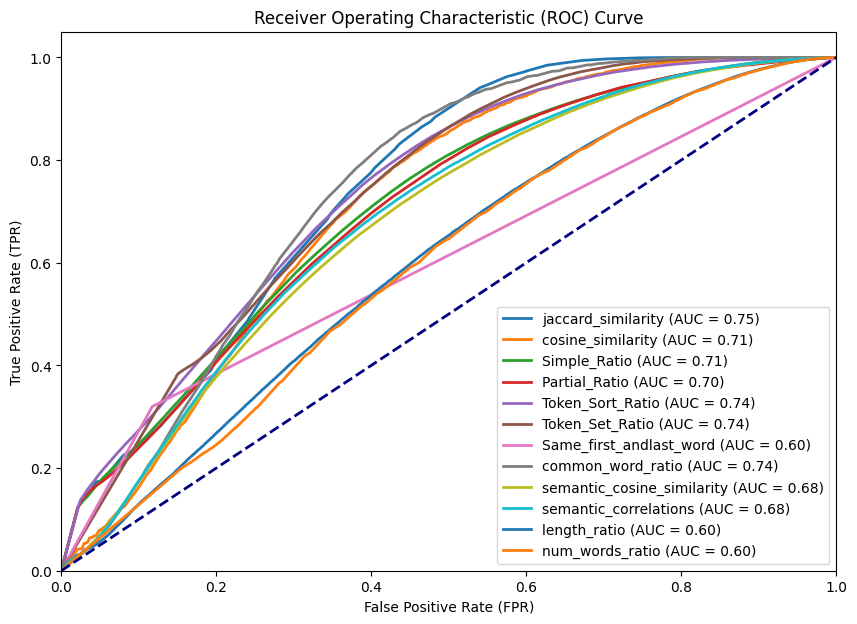

{'jaccard_similarity': 0.7466493668906704,
 'cosine_similarity': 0.7147925047921364,
 'Simple_Ratio': 0.7075274622575859,
 'Partial_Ratio': 0.7019475589656168,
 'Token_Sort_Ratio': 0.7405572779680573,
 'Token_Set_Ratio': 0.7357456389501154,
 'Same_first_andlast_word': 0.6012167036240326,
 'common_word_ratio': 0.7410276223477229,
 'semantic_cosine_similarity': 0.6775186687672199,
 'semantic_correlations': 0.684455020801613,
 'length_ratio': 0.6005554565082,
 'num_words_ratio': 0.5955176784731296}

In [ ]:
ROC(df,feature_list)

Plotting the ROC_AUC score and the accuracy of each individual feature were simply used to predict whether 2 questions are duplicate or not when their score >0.5. To get a simple gauge of how much better our model should do compared to individual features

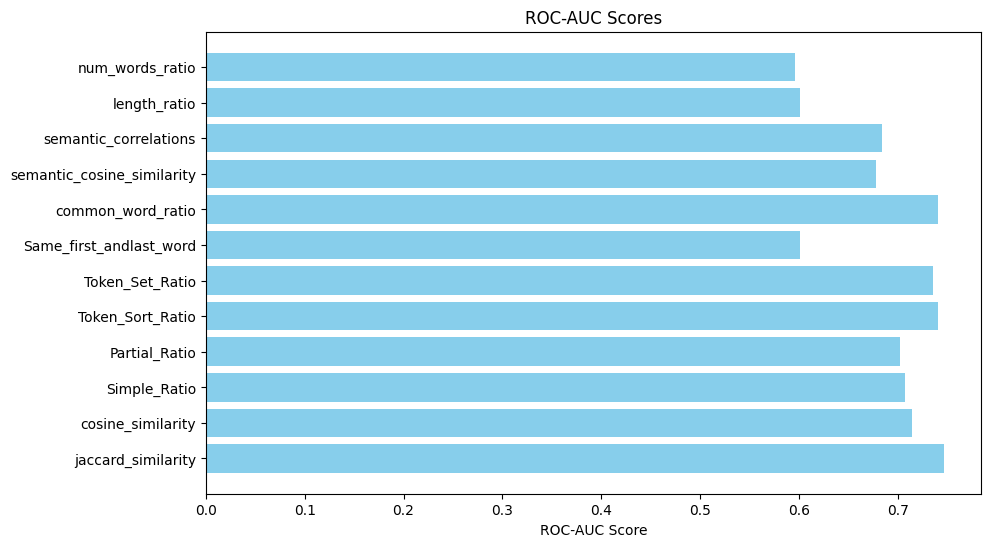

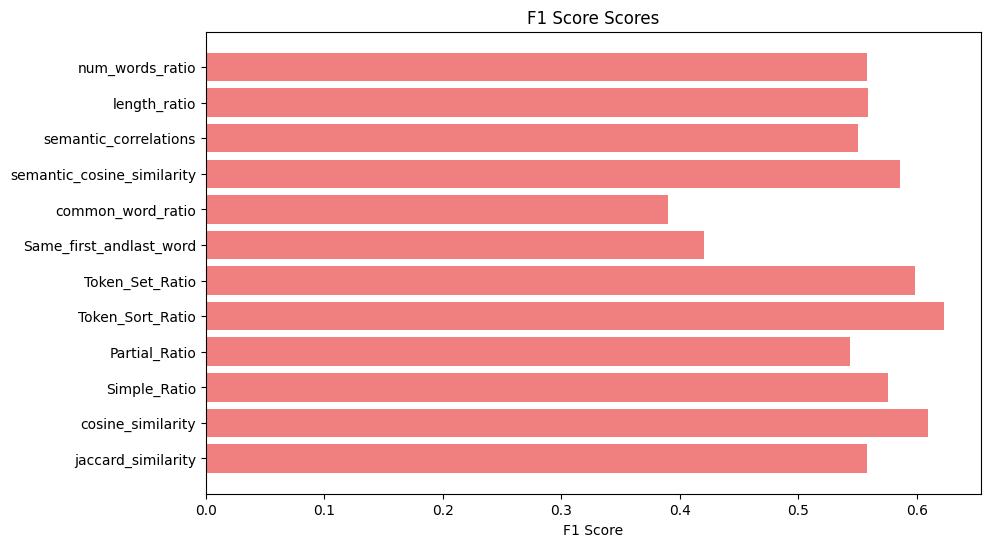

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_roc_auc(df, column):
    roc_auc = roc_auc_score(df['is_duplicate'], df[column])
    return roc_auc

def plot_roc_auc_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.barh(list(scores.keys()), list(scores.values()), color='skyblue')
    plt.xlabel('ROC-AUC Score')
    plt.title('ROC-AUC Scores')
    plt.show()

def print_roc_auc_scores(scores):
    for metric, value in scores.items():
        print(f"ROC-AUC Score {metric}: {value}")

def calculate_f1_score(df, column):
    predictions = (df[column] > 0.5).astype(int)
    f1 = f1_score(df['is_duplicate'], predictions)
    return f1

def plot_f1_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.barh(list(scores.keys()), list(scores.values()), color='lightcoral')
    plt.xlabel('F1 Score')
    plt.title('F1 Score Scores')
    plt.show()

def print_f1_scores(scores):
    for metric, value in scores.items():
        print(f"F1 Score {metric}: {value}")

roc_auc_scores = {}
f1_scores = {}

for column in feature_list:
    roc_auc_scores[column] = calculate_roc_auc(df, column)
    f1_scores[column] = calculate_f1_score(df, column)

plot_roc_auc_scores(roc_auc_scores)
plot_f1_scores(f1_scores)


# ML Algorithms

In [ ]:
from sklearn.model_selection import train_test_split

y = df['is_duplicate']
X = df[feature_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1) # 90% training and 10% test

## if we want to balance classes, do to X_train and y_train here

## Random classifier
This classifier serves as our baseline. It gives random predicitions of the output by replicating the class distribution in our dataset

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='stratified')

In [ ]:
evaluate_classification_model(dummy_classifier,X,y)

{'accuracy': 0.533930702201019,
 'f1_score': 0.36771539172476536,
 'precision': 0.3674435210452529,
 'recall': 0.3679952552865995,
 'roc_auc': 0.4993335443275425,
 'log_loss': 16.769959084444363}

## Logistic Regression with SGD
Logistic regression was used with stochastic gradient descent. Logistic regression with gradient descent could not converge for our model. We chose stochastic gradient descent to escape local minima and because it works better for our large dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
https://stackoverflow.com/questions/43961225/sgdclassifier-vs-logisticregression-with-sgd-solver-in-scikit-learn-library


In [ ]:
from sklearn.linear_model import SGDClassifier
logreg = SGDClassifier(loss='log_loss')

In [ ]:
evaluate_classification_model(logreg,X,y)

{'accuracy': 0.688306405704582,
 'f1_score': 0.5375611930774383,
 'precision': 0.5924763524733172,
 'recall': 0.4921792494830849,
 'roc_auc': 0.6473989104738938,
 'log_loss': 0.5433313871780998}

In [ ]:
## Model Interpretability
logreg.coef_

array([[ 0.01754018,  0.37552834,  0.96188267, -0.97047622,  1.10764676,
         3.00793066, -2.3603999 ,  0.5546709 ,  1.17774235, -2.94361607,
        -2.43298101,  4.33363648,  0.27479215, -0.227311  ]])

In [ ]:
## Feature Tuning (Unsuccessful)
## Using LDA or LDA with SMOTE will lead to less balanced precision and recall scores

from imblearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
logreg_with_lda = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('sgd', SGDClassifier(loss='log_loss'))
])
evaluate_classification_model(logreg_with_lda,X,y)



{'accuracy': 0.6890456677719677,
 'f1_score': 0.5274584693198789,
 'precision': 0.5990130429028392,
 'recall': 0.47187211714929356,
 'roc_auc': 0.6437742372923922,
 'log_loss': 0.5450171792435686}

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
logreg_with_smote_lda = Pipeline([
    ('smote', SMOTE(k_neighbors=50)),
    ('lda', LinearDiscriminantAnalysis()),
    ('sgd', SGDClassifier(loss='log_loss'))
])

evaluate_classification_model(logreg_with_smote_lda,X,y)

{'accuracy': 0.6911394387829544,
 'f1_score': 0.6392113996581531,
 'precision': 0.5609263927935323,
 'recall': 0.7429402401721571,
 'roc_auc': 0.7019463165097112,
 'log_loss': 0.5727598165927168}

Further tuning using linear discriminant analysis and SMOTE was attempted but these methods were still inferior as compared to tree-based methods.

We can see that LDA or LDA with SMOTE leads to unbalanced precision vs recall. Precision increases and recall drops with LDA and without SMOTE as predictions are more likely to be 0 due to imbalanced training data, which contains more 0s than 1s. However, with SMOTE, recall increases while precision drops as this technique unintentionally biases positive predictions, leading to high false positive rate.

These challenges show the lack of effectiveness of linear models for our dataset.

## LinearSVM with Kernel Approximation

For SVM, we tested the models with and without kernel approximation to find a kernel that best fits our dataset.

We noticed that the radial kernel improved performance for our dataset. This phenomenon is likely due to the complexity of textual dataset which has complex relationships. Therefore, the SVM with radial kernel approximation, which has increased expressivity outperformed the linear SVM.

In [ ]:
## SVM without kernel approx
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
linear_svm = CalibratedClassifierCV(estimator=LinearSVC(), method='sigmoid')
evaluate_classification_model(linear_svm,X,y)

{'accuracy': 0.691263478960028,
 'f1_score': 0.5420457305090041,
 'precision': 0.5973430682067729,
 'recall': 0.4961256401147905,
 'roc_auc': 0.6505769471082135,
 'log_loss': 0.5419804357706753}

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
rbf_feature = RBFSampler(gamma=1, n_components=100, random_state=1)
X_train_features = rbf_feature.fit_transform(X_train)
X_test_features = rbf_feature.transform(X_test)
svm = CalibratedClassifierCV(estimator=LinearSVC(), method='sigmoid')
svm.fit(X_train_features, y_train)

CalibratedClassifierCV(estimator=LinearSVC())

In [ ]:
evaluate_classification_model(svm,rbf_feature.transform(X),y)

{'accuracy': 0.7365102013518844,
 'f1_score': 0.6372744585132077,
 'precision': 0.646319395821417,
 'recall': 0.6284879028409306,
 'roc_auc': 0.7139874903120758,
 'log_loss': 0.47544193937123636}

## Decision Tree

From running the decision tree, we noticed that tree-based models perform better than linear and margin-based models as even a simple decision tree performed better. We therefore further tuned random forest and XGBoost which are more robust and better account for the complexity in our text dataset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion="entropy", max_depth=8)

In [ ]:
evaluate_classification_model(dt,X,y)

{'accuracy': 0.7251532474515126,
 'f1_score': 0.6500306299567027,
 'precision': 0.6139452486684069,
 'recall': 0.7030761387660049,
 'roc_auc': 0.7206860003469385,
 'log_loss': 0.46930748256666294}

In [ ]:
# dt.fit(X_train, y_train)
# # Get numerical feature importances
# importances = list(dt.feature_importances_)
# # List of tuples with variable and importance
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: jaccard_similarity   Importance: 0.55
Variable: common_word_ratio    Importance: 0.22
Variable: csc_ratio            Importance: 0.07
Variable: Token_Sort_Ratio     Importance: 0.05
Variable: semantic_correlations Importance: 0.04
Variable: cosine_similarity    Importance: 0.02
Variable: Token_Set_Ratio      Importance: 0.02
Variable: Same_first_andlast_word Importance: 0.02
Variable: semantic_euclidean_distance Importance: 0.01
Variable: Simple_Ratio         Importance: 0.0
Variable: Partial_Ratio        Importance: 0.0
Variable: semantic_cosine_similarity Importance: 0.0
Variable: length_ratio         Importance: 0.0
Variable: num_words_ratio      Importance: 0.0


Decision tree served as our baseline to consider improvements made by tree-based models.

## Random Forest

In [ ]:
# Using RandomForest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [ ]:
evaluate_classification_model(rf, X, y)

{'accuracy': 0.7686088540606052,
 'f1_score': 0.6980510240619683,
 'precision': 0.6719645197645482,
 'recall': 0.7262518906184059,
 'roc_auc': 0.7597788914205525,
 'log_loss': 0.43269257398529265}

In [ ]:
# rf.fit(X_train, y_train)
# # Get numerical feature importances
# importances = list(rf.feature_importances_)
# # List of tuples with variable and importance
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: common_word_ratio    Importance: 0.14
Variable: jaccard_similarity   Importance: 0.09
Variable: cosine_similarity    Importance: 0.08
Variable: Token_Sort_Ratio     Importance: 0.08
Variable: Token_Set_Ratio      Importance: 0.08
Variable: semantic_euclidean_distance Importance: 0.08
Variable: semantic_correlations Importance: 0.08
Variable: csc_ratio            Importance: 0.07
Variable: length_ratio         Importance: 0.07
Variable: Simple_Ratio         Importance: 0.06
Variable: Partial_Ratio        Importance: 0.06
Variable: semantic_cosine_similarity Importance: 0.06
Variable: num_words_ratio      Importance: 0.04
Variable: Same_first_andlast_word Importance: 0.01


## XGBoost

In [ ]:
# Using xgbClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier()

In [ ]:
evaluate_classification_model(xgb,X,y)

{'accuracy': 0.7649596478127421,
 'f1_score': 0.7081299938326261,
 'precision': 0.6524490344245761,
 'recall': 0.7742079648153656,
 'roc_auc': 0.7668882424390121,
 'log_loss': 0.42783683704279596}

In [ ]:
# # Get numerical feature importances
# importances = list(xgb.feature_importances_)
# # List of tuples with variable and importance
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: jaccard_similarity   Importance: 0.49000000953674316
Variable: common_word_ratio    Importance: 0.12999999523162842
Variable: Same_first_andlast_word Importance: 0.09000000357627869
Variable: Token_Sort_Ratio     Importance: 0.05999999865889549
Variable: csc_ratio            Importance: 0.05999999865889549
Variable: Token_Set_Ratio      Importance: 0.03999999910593033
Variable: semantic_correlations Importance: 0.03999999910593033
Variable: cosine_similarity    Importance: 0.029999999329447746
Variable: semantic_euclidean_distance Importance: 0.019999999552965164
Variable: num_words_ratio      Importance: 0.019999999552965164
Variable: Simple_Ratio         Importance: 0.009999999776482582
Variable: Partial_Ratio        Importance: 0.009999999776482582
Variable: semantic_cosine_similarity Importance: 0.009999999776482582
Variable: length_ratio         Importance: 0.009999999776482582


## End of ML Algorithms

# Improving best 2 models

### Hyperparameter tuning for best 2 models

In [ ]:
# Import packages required for hyperparameter tuning

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit

While thinking of what parameters to set, we considered that the dataset was relatively big and started from hyperparameters normally considered for large dataset. Then we started to find the range of

In [ ]:
# Finding of best parameters for random forest classifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit

splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

rf_param_grid = {
    'n_estimators':[400, 600, 800],
    'min_samples_split':[5, 10, 15],
    'max_depth': [70, 150, None]
}

rf_clf = RandomForestClassifier()

rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

rf_clf_search.fit(X_train, y_train)

rf_clf_search.best_params_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 22674
max_resources_: 362790
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 27
n_resources: 22674
Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200;, score=(train=0.997, test=0.749) total time=  12.5s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500;, score=(train=0.998, test=0.749) total time=  20.1s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800;, score=(train=0.998, test=0.750) total time=  40.5s
[CV 1/1] END max_depth=70, min_samples_split=10, n_estimators=200;, score=(train=0.982, test=0.752) total time=   5.9s
[CV 1/1] END max_depth=70, min_samples_split=10, n_estimators=500;, score=(train=0.982, test=0.751) total time=  16.2s
[CV 1/1] END max_depth=70, min_samples_split=10, n_estimators=800;, score=(train=0.983, test=0.748) total time=  26.2s
[CV 1/1] END max_depth

{'max_depth': None, 'min_samples_split': 15, 'n_estimators': 800}

In [ ]:
rf_tuned = RandomForestClassifier(max_depth = None, min_samples_split = 15, n_estimators = 800)
evaluate_classification_model(rf_tuned,X,y)

{'accuracy': 0.7710276052041832,
 'f1_score': 0.7064649951723214,
 'precision': 0.6691694063669615,
 'recall': 0.7481699790373618,
 'roc_auc': 0.7662628286631501,
 'log_loss': 0.42511917857347586}

In [ ]:
# Finding of best parameters for xgboostClassifier
splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

xgb_param_grid = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [4, 8, 12],
    'eta': [0.15, 0.3, 0.45]
}

xgb_clf = XGBClassifier()

xgb_clf_search = HalvingGridSearchCV(xgb_clf, xgb_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

xgb_clf_search.fit(X_train, y_train)

xgb_clf_search.best_params_

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 5668
max_resources_: 362790
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 81
n_resources: 5668
Fitting 1 folds for each of 81 candidates, totalling 81 fits
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=4, subsample=0.6;, score=(train=0.853, test=0.734) total time=   0.2s
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=4, subsample=0.8;, score=(train=0.859, test=0.744) total time=   0.1s
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=4, subsample=1.0;, score=(train=0.852, test=0.748) total time=   0.1s
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=8, subsample=0.6;, score=(train=0.993, test=0.737) total time=   0.3s
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=8, subsample=0.8;, score=(train=0.997, test=0.740) total time=   0.4s
[CV 1/1] END colsample_bytree=0.6, eta=0.15, max_depth=8, subsample=1.0;, score=(train=0.988, test=0.743) tota

{'colsample_bytree': 1.0, 'eta': 0.15, 'max_depth': 8, 'subsample': 0.8}

In [ ]:
# Best parameters for xGBoost are colsample_bytree = 1.0, eta = 0.15, max_depth = 8, subsample = 0.8, reg_lambda = 1, reg_alpha = 1)

xgb_tuned = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    booster = "gbtree",
    tree_method = "hist",
    grow_policy = "lossguide",
    max_depth = 8,
    eta = 0.15,
    subsample = .8,
    colsample_bytree = 1.0,
    reg_lambda = 1,
    reg_alpha = 1
    )

evaluate_classification_model(xgb_tuned,X,y)

{'accuracy': 0.7671055106775333,
 'f1_score': 0.7110569277719172,
 'precision': 0.6546475746715681,
 'recall': 0.7781068587575743,
 'roc_auc': 0.7693987409962686,
 'log_loss': 0.4260331311982231}

### Recursive Feature Selection for 2 best models

#### RandomForest

In [ ]:
import numpy as np

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data

num_rows = len(X)

# Set a seed for reproducibility
np.random.seed(42)

# Randomly sample 100,000 indices
sample_indices = np.random.choice(num_rows, 40000, replace=False)

# Use the sampled indices to select rows from X and y
X_sampled = X.iloc[sample_indices]
y_sampled = y.iloc[sample_indices]

In [ ]:
from yellowbrick.model_selection import RFECV

rf = RandomForestClassifier(n_estimators=800, max_depth=None ,min_samples_split=15 , n_jobs=-1)
visualizer = RFECV(rf, step=2, min_features_to_select = 10 , cv = 4, verbose =1, n_jobs=-1)


visualizer.fit(X_sampled, y_sampled)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Get the selected features based on support
selected_features = X_sampled.columns[visualizer.support_]

# Access the feature rankings and support
feature_rankings = visualizer.ranking_
feature_support = visualizer.support_
# Access the underlying RandomForestClassifier from the visualizer
rf_estimator = visualizer.estimator_

# Access feature importances
feature_importances = rf_estimator.feature_importances_

# Print feature rankings along with names and support
print("Feature Rankings with Names and Support:")
for name, rank, importance, support in zip(X_sampled.columns, feature_rankings,feature_importances, feature_support):
    selected = 'Selected' if support else 'Not Selected'
    print(f"Feature: {name}, Rank: {rank}, Importance: {round(importance,2)} | {selected}")


#### XGBoost

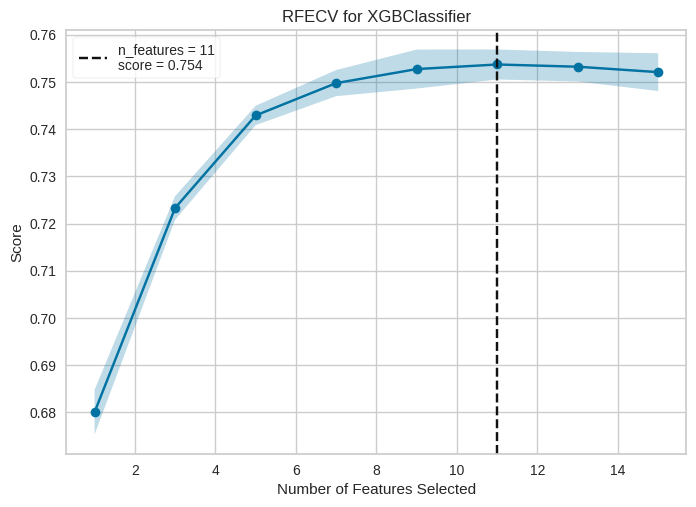

<Axes: title={'center': 'RFECV for XGBClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [ ]:
from yellowbrick.model_selection import RFECV

xgb = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    booster = "gbtree",
    tree_method = "hist",
    grow_policy = "lossguide",
    max_depth = 4,
    eta = 0.15,
    subsample = .8,
    colsample_bytree = .8,
    reg_lambda = 1,
    reg_alpha = 1
    )
visualizer = RFECV(xgb, step=2, min_features_to_select = 10)


visualizer.fit(X_sampled, y_sampled)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Get the selected features based on support
selected_features = X_sampled.columns[visualizer.support_]

# Access the feature rankings and support
feature_rankings = visualizer.ranking_
feature_support = visualizer.support_
# Access the underlying RandomForestClassifier from the visualizer
xgb_estimator = visualizer.estimator_

# Access feature importances
feature_importances = xgb_estimator.feature_importances_

# Print feature rankings along with names and support
print("Feature Rankings with Names and Support:")
for name, rank, importance, support in zip(X_sampled.columns, feature_rankings,feature_importances, feature_support):
    selected = 'Selected' if support else 'Not Selected'
    print(f"Feature: {name}, Rank: {rank}, Importance: {round(importance,2)} | {selected}")

Feature Rankings with Names and Support:
Feature: jaccard_similarity, Rank: 1, Importance: 0.25999999046325684 | Selected
Feature: cosine_similarity, Rank: 1, Importance: 0.03999999910593033 | Selected
Feature: Simple_Ratio, Rank: 2, Importance: 0.09000000357627869 | Not Selected
Feature: Partial_Ratio, Rank: 3, Importance: 0.07000000029802322 | Not Selected
Feature: Token_Sort_Ratio, Rank: 1, Importance: 0.07000000029802322 | Selected
Feature: Token_Set_Ratio, Rank: 1, Importance: 0.10000000149011612 | Selected
Feature: csc_ratio, Rank: 1, Importance: 0.27000001072883606 | Selected
Feature: Same_first_andlast_word, Rank: 1, Importance: 0.029999999329447746 | Selected
Feature: common_word_ratio, Rank: 1, Importance: 0.03999999910593033 | Selected
Feature: semantic_cosine_similarity, Rank: 3, Importance: 0.019999999552965164 | Not Selected
Feature: semantic_euclidean_distance, Rank: 1, Importance: 0.019999999552965164 | Selected


## Final Model Performance of Best ML models
with hyperparameters tunings and recursive feature selection

In [ ]:
# RandomForest

evaluate_classification_model(rf_estimator,X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'accuracy': 0.7708787584871566,
 'f1_score': 0.706488377546867,
 'precision': 0.6687519302543097,
 'recall': 0.7487458976093654,
 'roc_auc': 0.766264691136466,
 'log_loss': 0.42505971358081407}

In [ ]:
# XGBoost

evaluate_classification_model(xgb_estimator,X,y)

{'accuracy': 0.7573164000073346,
 'f1_score': 0.6976273442411073,
 'precision': 0.6446081317917857,
 'recall': 0.7601603053158726,
 'roc_auc': 0.757908610372511,
 'log_loss': 0.44025594843871474}

In [ ]:
import joblib


# saving the rf tuned model model
joblib.dump(rf_estimator, "rf_estimator.joblib")

# saving the xgb_tuned model model
joblib.dump(xgb_estimator, "xgb_estimator.joblib")

['xgb_estimator.joblib']

In [20]:
import joblib

#loading rf_tuned
rf_tuned = joblib.load("rf_estimator.joblib")


# loading xgb_tuned
xgb_tuned = joblib.load("xgb_estimator.joblib")

#rf_tuned

In [ ]:
xgb_tuned

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.15, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Packaged Function
use this to tests whether 2 questions are similar based on our best model.
the similarity_check function is a simple package of the feature engineering that we have done throughout the project for our model and returns a probability of the two questions being duplicate using our best model.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from google.colab import files
nlp_model = spacy.load('en_core_web_lg')
import re
import json
import ast


In [18]:
feature_list = ["jaccard_similarity", "cosine_similarity", "Simple_Ratio", "Partial_Ratio", "Token_Sort_Ratio", "Token_Set_Ratio", "csc_ratio", "Same_first_andlast_word", "common_word_ratio", "semantic_cosine_similarity", "semantic_euclidean_distance"]


In [70]:
#Main function which takes in two questions and a model and returns the similarity score given by our model from 0 to 1
from tqdm import tqdm

def similarity_check(question1, question2, model):
  data = {"question1": [question1,], "question2" : [question2,]}
  df = pd.DataFrame(data)
  df["question1"]=df["question1"].apply(to_lower)
  df["question2"]=df["question2"].apply(to_lower)
  df["question1"]=df["question1"].apply(expand_contractions)
  df["question2"]=df["question2"].apply(expand_contractions)
  df["question1"]=df["question1"].apply(remove_html_tags)
  df["question2"]=df["question2"].apply(remove_html_tags)
  df["question1"]=df["question1"].apply(standardize_accented_chars)
  df["question2"]=df["question2"].apply(standardize_accented_chars)
  df["question1"]=df["question1"].apply(remove_mentions_and_tags)
  df["question2"]=df["question2"].apply(remove_mentions_and_tags)
  df["q1_length"] = df["question1"].str.len()
  df["q2_length"] = df["question2"].str.len()
  df['question1_tokens'] = df['question1'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)
  df['question2_tokens'] = df['question2'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)
  df["jaccard_similarity"] = df.apply(calculate_jaccard_similarity, axis=1)
  df['cosine_similarity'] = df.apply(lambda row: cosine_similarity_strings(row['question1'], row['question2']), axis=1)
  df['Simple_Ratio']=df.apply(lambda x: fuzz.ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)
  df['Partial_Ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1_tokens'],x['question2_tokens'])/100,axis=1)
  df['Token_Sort_Ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)
  df['Token_Set_Ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['question1_tokens'],x['question2_tokens'])/100 ,axis=1)
  df['common_word_ratio']= df.apply(lambda row: common_word_ratio(row['question1'], row['question2']), axis=1)
  df['Same_first_andlast_word']= df.apply(lambda row: share_same_firstandlast_word(row['question1'], row['question2']), axis=1)
  df['common_word_ratio']= df.apply(lambda row: common_word_ratio(row['question1'], row['question2']), axis=1)
  df['csc_ratio']= df.apply(lambda row: common_stopwords_ratio(row['question1'], row['question2']), axis=1)
  df['q1_length'] = df['question1'].str.len()
  df['q2_length'] = df['question2'].str.len()
  df['length_ratio'] = df[['q1_length', 'q2_length']].min(axis=1) / df[['q1_length', 'q2_length']].max(axis=1)
  df['q1_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
  df['q2_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
  df['num_words_ratio'] = df[['q1_words', 'q2_words']].min(axis=1) / df[['q1_words', 'q2_words']].max(axis=1)

  questions = list(df['question1']) + list(df['question2'])
  questions = [str(text) for text in questions if not pd.isnull(text)]
  tfidf = TfidfVectorizer(lowercase=False, )
  tfidf.fit_transform(questions)
  word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
  df_qns = pd.DataFrame()
  vecs1 = []
  df['question1'] = df['question1'].astype(str)
  for qu1 in tqdm(list(df['question1'])):
      doc = nlp_model(qu1)
      mean_vec1 = np.zeros([len(doc), len(doc[0].vector)])
      for word in doc:
          vec1 = word.vector
          try:
              idf = word2tfidf[str(word)]
          except:
              idf = 0
          mean_vec1 += vec1 * idf
      mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)
  df_qns = pd.DataFrame()
  df_qns['q1_feats'] = list(vecs1)
  df_qns1 = df_qns
  vecs2 = []
  df_qns2 = pd.DataFrame()
  for qu2 in tqdm(list(df['question2'])):
      doc = nlp_model(qu2)
      mean_vec2 = np.zeros([len(doc), len(doc[0].vector)])
      for word in doc:
          vec2 = word.vector
          try:
              idf = word2tfidf[str(word)]
          except:
              idf = 0
          mean_vec2 += vec2 * idf
      mean_vec2 = mean_vec2.mean(axis=0)
      vecs2.append(mean_vec2)
  df_qns2['q2_feats'] = list(vecs2)
  df_qns1 = pd.concat([df_qns1['q1_feats'].apply(pd.Series)], axis=1)
  df_qns1.columns = ['qn1_' + str(col) for col in df_qns1.columns]
  df_qns2 = pd.concat([df_qns2['q2_feats'].apply(pd.Series)], axis=1)
  df_qns2.columns = ['qn2_' + str(col) for col in df_qns1.columns]
  result_df = pd.merge(df, df_qns1, left_index=True, right_index=True)
  result_df = pd.merge(result_df, df_qns2, left_index=True, right_index=True)
  q1_feats = [col for col in result_df.columns if 'qn1_' in col]
  q2_feats = [col for col in result_df.columns if 'qn2_' in col]

  cosine_similarities = []
  euclidean_distances = []
  for qn1_col, qn2_col in zip(q1_feats, q2_feats):
      cosine_similarity = [np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)) for x, y in zip(result_df[qn1_col], result_df[qn2_col])]
      cosine_similarities.append(cosine_similarity)
      euclidean_distance = [np.linalg.norm(x - y) for x, y in zip(result_df[qn1_col], result_df[qn2_col])]
      euclidean_distances.append(euclidean_distance)
  df['semantic_cosine_similarity'] = np.mean(cosine_similarities, axis=0)
  df['semantic_euclidean_distance'] = np.mean(euclidean_distances, axis=0)
  newdf = df[feature_list].copy()
  return model.predict(newdf)[0]

similarity_check("why is the sun round?", "why is the sun so round?",xgb_tuned)

100%|██████████| 1/1 [00:00<00:00, 100.38it/s]


1

pick a few examples to try our main model on to examine why our model predicts wrongly for some pair of questions

In [71]:
sample_test = df_kaggle_train[df_kaggle_train["is_duplicate"]==1][:100]

In [73]:
sample_test["model"] = sample_test.apply(lambda row: similarity_check(row['question1'], row['question2'],xgb_tuned), axis=1)

100%|██████████| 1/1 [00:00<00:00, 120.78it/s]
<ipython-input-5-306f714d1fd4>:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
100%|██████████| 1/1 [00:00<00:00, 114.50it/s]
<ipython-input-5-306f714d1fd4>:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
100%|██████████| 1/1 [00:00<00:00, 110.13it/s]
<ipython-input-5-306f714d1fd4>:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
100%|██████████| 1/1 [00:00<00:00, 101.04it/s]


randomly pick False Negative example data that was marked as is_duplicate but our model failed to predict, thus classifying it as not duplicate

In [79]:
test_is_duplicate = sample_test[sample_test["is_duplicate"]==1]
test_False_Negative = test_is_duplicate[test_is_duplicate["model"]==0]

In [80]:
question1 = test_False_Negative["question1"].values[0]
question2 = test_False_Negative["question2"].values[0]

isSimilar = similarity_check(question1, question2 ,xgb_tuned)
output = "\n" + "Question1: " + question1 + "\n" + "Question2: " + question2 + "\n"
if isSimilar:
  output += "are duplicate"
else:
  output += "are not duplicate"

print(output)

100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


Question1: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
are not duplicate


Here we can see that although 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?' and 'I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?' are labeled as duplicate our model marks them as not duplicate. Perhaps because the idea that there is a limited amount of different astrology terminology and cap rising most probably means the same as ascendent is not captured by our model.

In [87]:
question1 = test_False_Negative["question1"].values[11]
question2 = test_False_Negative["question2"].values[11]

isSimilar = similarity_check(question1, question2 ,xgb_tuned)
output = "\n" + "Question1: " + question1 + "\n" + "Question2: " + question2 + "\n"
if isSimilar:
  output += "are duplicate"
else:
  output += "are not duplicate"

print(output)

100%|██████████| 1/1 [00:00<00:00, 85.17it/s]


Question1: What Game of Thrones villain would be the most likely to give you mercy?
Question2: What Game of Thrones villain would you most like to be at the mercy of?
are not duplicate


Here we can see that although 'What Game of Thrones villain would be the most likely to give you mercy?' and 'What Game of Thrones villain would you most like to be at the mercy of?' were labeled as is_duplicate our model predicted it as not duplicate, perhabs our model failed to realise that a villain that would most likely to give you mercy would also be one where by you would most like to be a the the mercy of. The order and the meaning of the words might have thrown our model off.

randomly pick a False Postive example data that was marked as not is_duplicate but our model predicts the questions as duplicate

In [84]:
test_not_is_duplicate = sample_test[sample_test["is_duplicate"]==0]
test_False_Positive = test_is_duplicate[test_is_duplicate["model"]==1]

In [85]:
question1 = test_False_Positive["question1"].values[0]
question2 = test_False_Positive["question2"].values[0]

isSimilar = similarity_check(question1, question2 ,xgb_tuned)
output = "\n" + "Question1: " + question1 + "\n" + "Question2: " + question2 + "\n"
if isSimilar:
  output += "are duplicate"
else:
  output += "are not duplicate"

print(output)

100%|██████████| 1/1 [00:00<00:00, 100.60it/s]


Question1: What is a narcissistic personality disorder?
Question2: What is narcissistic personality disorder?
are duplicate


it seems like our model did not have a False Positive but the training data had labeled the question as not is_duplicate wrongly.

Manual testing of some similar duplicate questions as a sanity check of the performance of our model

In [78]:
question1 = "what color is a pear?"
question2 = "what is the color of a pear?"

isSimilar = similarity_check(question1, question2 ,xgb_tuned)
output = "\n" + "Question1: " + question1 + "\n" + "Question2: " + question2 + "\n"
if isSimilar:
  output += "are duplicate"
else:
  output += "are not duplicate"

print(output)

100%|██████████| 1/1 [00:00<00:00, 15.93it/s]



Question1: what color is a pear?
Question2: what is the color of a pear?
are duplicate
